<ipython-input-2-175811d23897>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_2['2022'] = new_df_2['2022'] * new_df_2['CAPACITY_KWH']
<ipython-input-2-175811d23897>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_2['2021'] = new_df_2['2021'] * new_df_2['CAPACITY_KWH']
<ipython-input-2-175811d23897>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

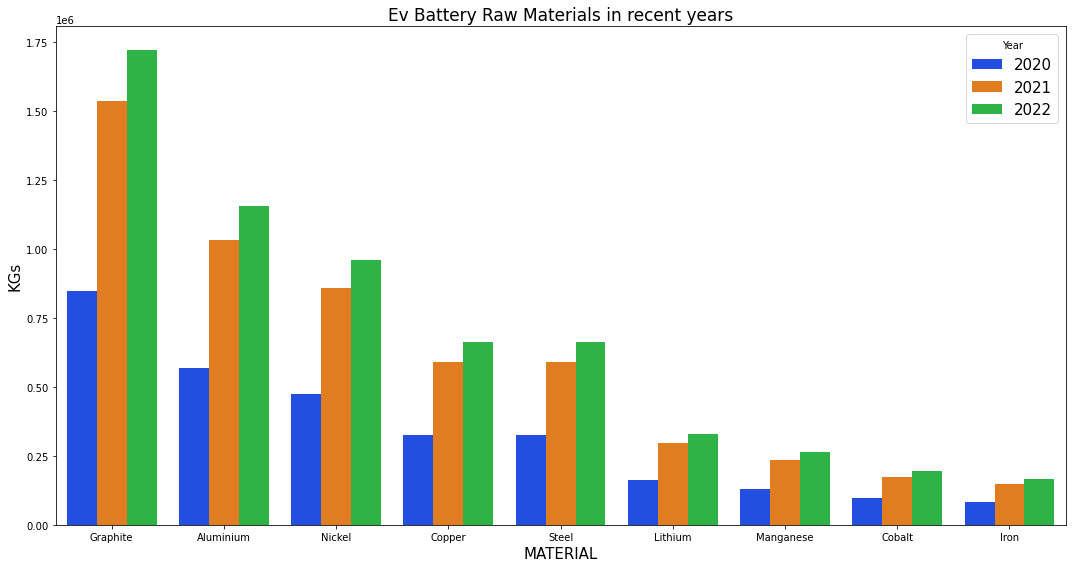

In [2]:
####### 1_4 EV Battery Raw Materials  ################
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'csv_url' file link
csv_url = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/1_4/VEH0171b_GenModels.csv?token=GHSAT0AAAAAACFKR6ACSQA43JKNARC5QQMOZGI4YTA'

# Read the CSV file into a DataFrame, skipping the first 4 rows
df = pd.read_csv(csv_url, skiprows=4)

# Save the first four columns in a separate DataFrame with the renamed names
first_four_columns = df.iloc[:, :6].rename(columns={df.columns[2]: 'BODY TYPE', df.columns[3]: 'MAKE', df.columns[4]: 'MODEL', df.columns[5]: 'FUEL'})

# Drop the first two columns from the original DataFrame
df.drop(df.columns[:4], axis=1, inplace=True)

# Create a new DataFrame to store the sums
sum_df = pd.DataFrame(index=df.index)

# Iterate through columns and group by left 4 characters of the header
for col in df.columns:
    header_prefix = col[:4]
    if header_prefix not in sum_df.columns:
        selected_columns = df.loc[:, df.columns.str[:4] == header_prefix]
        sum_df[header_prefix] = pd.to_numeric(selected_columns.stack(), errors='coerce').groupby(level=0).sum()

# Print the first few rows of the new DataFrame with sums and the first four columns unchanged
result_df = pd.concat([first_four_columns, sum_df], axis=1)
new_df = result_df.drop(result_df.columns[[0, 1, 6, 7]], axis=1)

# Calculate the sum of numbers from the 5th column till the last column and add a new "TOTAL" column
new_df['TOTAL'] = new_df[new_df.columns[2:]].sum(axis=1)

# Filter out rows where 'MODEL' column contains the string "MISSING"
clean_data = new_df[~new_df['MODEL'].str.contains("MISSING")]

##################################################################
# Manually replace the EV battery capacity data file path

csv_url2 = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/1_4/EV_CAPACITY.csv?token=GHSAT0AAAAAACFKR6ADVYPPKKO4JWATWFJUZGI4WWQ'
df2 = pd.read_csv(csv_url2)
df2.columns = df2.columns.str.upper()
# print(df2)
###################################################################
# merging both the data frames
clean_data = clean_data.merge(df2[['MODEL', 'BODY_TYPE', 'CAPACITY_KWH']], on='MODEL', how='left')

# Drop rows with NaN values in the 'BODY_TYPE' column
clean_data.dropna(subset=['BODY_TYPE'], inplace=True)

# List of body types to categorize
main_body_types = ['Sedan', 'SUV', 'Hatchback', 'Van']

# Categorize 'BODY TYPE' column as Sedan, SUV, Hatchback, Van, and "Others"
clean_data['BODY_TYPE_CATEGORIZED'] = clean_data['BODY_TYPE'].where(clean_data['BODY_TYPE'].isin(main_body_types), 'Others')
########################################################################

new_df_2 = clean_data[['CAPACITY_KWH','2022','2021','2020']]
new_df_2['2022'] = new_df_2['2022'] * new_df_2['CAPACITY_KWH']
new_df_2['2021'] = new_df_2['2021'] * new_df_2['CAPACITY_KWH']
new_df_2['2020'] = new_df_2['2020'] * new_df_2['CAPACITY_KWH']

# print(new_df_2)
# Calculate the total of column values
column_totals = new_df_2.sum()

# Convert the column totals Series to a DataFrame
column_totals_df = pd.DataFrame(column_totals, columns=['Total'])
column_totals_df = column_totals_df.T
column_totals_df = column_totals_df.drop('CAPACITY_KWH', axis=1)
# print(column_totals_df)

# Create a DataFrame with the given percentages and materials
materials_data = {
    'Percentage': [0.2810, 0.1890, 0.1570, 0.1080, 0.1080, 0.0540, 0.0430, 0.0320, 0.0270],
    'Material': ['Graphite', 'Aluminium', 'Nickel', 'Copper', 'Steel', 'Lithium', 'Manganese', 'Cobalt', 'Iron']
}

materials_df = pd.DataFrame(materials_data)
# print(materials_df)

for year in ['2020', '2021', '2022']:
    materials_df[year] = column_totals_df[year].values * materials_df['Percentage']

    
# Melt the DataFrame to convert columns to rows for plotting
df2_melted = materials_df.melt(id_vars=['Material', 'Percentage'], var_name='Year', value_name='Value')

# Create a clustered bar plot using Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(data=df2_melted, x='Material', y='Value', hue='Year', palette='bright')
plt.title('Ev Battery Raw Materials in recent years',fontsize = 17)
plt.xlabel('MATERIAL',fontsize = 15)
plt.ylabel('KGs',fontsize = 15)
plt.legend(title='Year', loc='upper right',fontsize = 15)
plt.tight_layout()
plt.show()

# print(materials_df) 
